# Práctica: Evaluación Metodologías de Data Streams | Histogramas

- Asignatura: Datos temporales y complejos
- Autor: Mira Abad, Alejandro

In [60]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
class HistogramEqualFrequency:
    '''
    La clase HistogramEqualFrequency genera un histogramo donde cada "cubo" tiene aproximadamente la misma frecuencia total.
    Los datos se dividen en "cubos" de manera que la suma total de las frecuencias en cada cubo sea aproximadamente la misma.

    Atributos
    ----------
    frequencies : list
        Una lista de las frecuencias de los datos.
    num_buckets : int
        El número de "cubos" que se deben formar.
    N : int
        El número de datos.

    Métodos
    -------
    __init__(self, frequencies, num_buckets):
        Inicializa una instancia de HistogramEqualFrequency.

    generate(self):
        Genera el histograma de frecuencia igual.

    save_histogram(self, directory):
        Guarda el histograma generado en la ubicación especificada.
    '''
    def __init__(self, frequencies, num_buckets):
        self.frequencies = frequencies
        self.num_buckets = num_buckets
        self.N = len(frequencies)

    def generate(self):
        total_freq = sum(self.frequencies)
        freq_per_bucket = total_freq // self.num_buckets
        
        self.bucket_limits = []
        self.bucket_indices = [[] for _ in range(self.num_buckets)]
        cumulative_freq = 0
        current_bucket = 0
        for i in range(self.N):
            cumulative_freq += self.frequencies[i]
            self.bucket_indices[current_bucket].append(i+1)
            if cumulative_freq >= freq_per_bucket and current_bucket < self.num_buckets-1:
                self.bucket_limits.append(i+1)
                cumulative_freq -= freq_per_bucket
                current_bucket += 1

        # Añade el límite del último cubo
        if len(self.bucket_limits) < self.num_buckets:
            self.bucket_limits.append(self.N)

        # Corregir si hemos añadido un cubo de más
        if len(self.bucket_limits) > self.num_buckets:
            self.bucket_limits = self.bucket_limits[:-1]
        
        self.bucket_freqs = [freq_per_bucket]*self.num_buckets
        self.bucket_freqs[-1] += total_freq - freq_per_bucket*self.num_buckets   # añade el resto al último cubo

    def save_histogram(self, directory):
        plt.figure(figsize=(10,7)) 
        plt.bar(range(1, self.num_buckets+1), self.bucket_freqs, tick_label=[str(indices) for indices in self.bucket_indices])
        plt.title('Histograma de los cubos')
        plt.xlabel('Cubos')
        plt.ylabel('Frecuencia')
        plt.savefig(f'{directory}/histogram.png')

In [62]:
class HistogramGeneratorVOpt:
    '''
    La clase HistogramGeneratorVOpt es responsable de generar un histograma basado en el algoritmo V-opt.
    Los datos se dividen en "cubos" de manera que se minimice la suma de los errores cuadrados dentro de los cubos.

    Atributos
    ----------
    frequencies : list
        Una lista de las frecuencias de los datos.
    num_buckets : int
        El número de "cubos" que se deben formar.
    N : int
        El número de datos.

    Métodos
    -------
    __init__(self, frequencies, num_buckets):
        Inicializa una instancia de HistogramGeneratorVOpt.

    sq_error(self, a, b):
        Calcula y devuelve el error cuadrado entre los puntos a y b.

    generate(self):
        Genera el histograma utilizando el algoritmo V-opt.

    save_histogram(self, directory):
        Guarda el histograma generado en la ubicación especificada.
    '''
    def __init__(self, frequencies, num_buckets):
        self.frequencies = frequencies
        self.num_buckets = num_buckets
        self.N = len(frequencies)

    def sq_error(self, a, b):
        s2 = self.PP[b] - self.PP[a]
        s1 = self.P[b] - self.P[a]
        return (s2 - s1*s1/(b-a+1))

    def generate(self):
        self.P = np.zeros(self.N+1)
        self.PP = np.zeros(self.N+1)
        BestErr = np.full((self.num_buckets+1, self.N+1), np.inf)
        self.index = np.zeros(self.N+1, dtype=int)
        self.bucket_indices = [[] for _ in range(self.num_buckets)]

        for i in range(1, self.N+1):
            self.P[i] = self.P[i-1] + self.frequencies[i-1]
            self.PP[i] = self.PP[i-1] + (self.frequencies[i-1] ** 2)

        for i in range(1, self.N+1):
            BestErr[1][i] = self.sq_error(1,i)

        self.index[1] = 1

        for k in range(1, self.num_buckets+1):
            for i in range(1, self.N+1):
                for j in range(1, i):
                    temp = BestErr[k-1][j] + self.sq_error(j+1,i)
                    if temp < BestErr[k][i]:
                        BestErr[k][i] = temp
                        self.index[i] = j + 1

        j = self.N
        i = self.num_buckets
        while i >= 2:
            end_point = j
            j = self.index[j]
            self.bucket_indices[i-1] = list(range(j, end_point+1))
            j -= 1
            i -= 1
        self.bucket_indices[0] = list(range(1, j+1)) 

        bucket_freqs = []
        j = self.N
        for i in range(self.num_buckets, 1, -1):
            end_point = j
            j = self.index[j]
            bucket_freqs.append(self.P[end_point] - self.P[j-1])  
            j -= 1
        bucket_freqs.append(self.P[j])

        self.bucket_freqs = bucket_freqs[::-1]  # reverse the list

    def save_histogram(self, directory):
        plt.figure(figsize=(10,7))  # adjust as needed
        plt.bar(range(1, self.num_buckets+1), self.bucket_freqs, tick_label=[str(indices) for indices in self.bucket_indices])
        plt.title('Histograma de los cubos')
        plt.xlabel('Cubos')
        plt.ylabel('Frecuencia')
        plt.savefig(f'{directory}/histogramVopt.png')

In [66]:
# Main
f = [7,3,4,5,9,10,8,1,9,4]  # your frequencies
B = 6  # your number of buckets

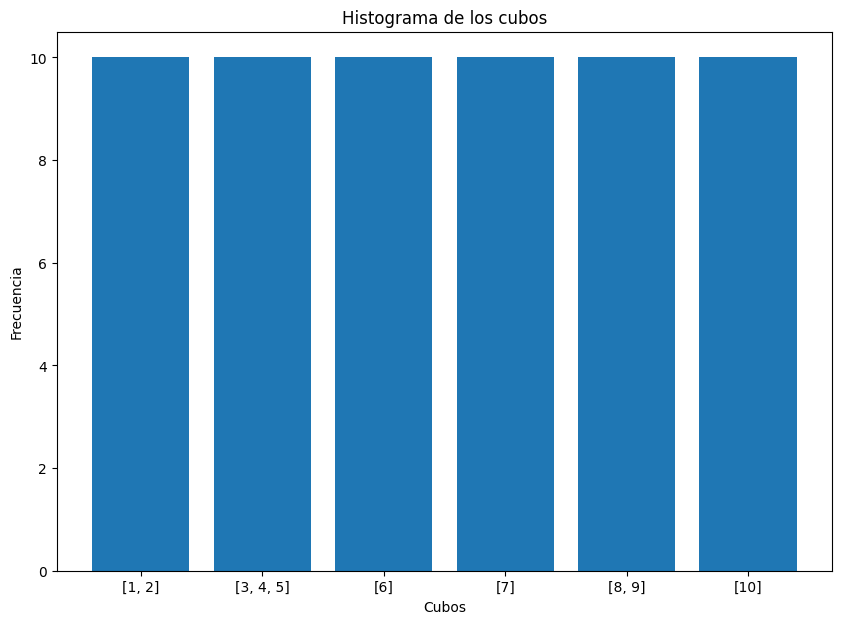

In [67]:
hist_generator = HistogramEqualFrequency(f, B)
hist_generator.generate()
hist_generator.save_histogram('./src')  # specify your directory

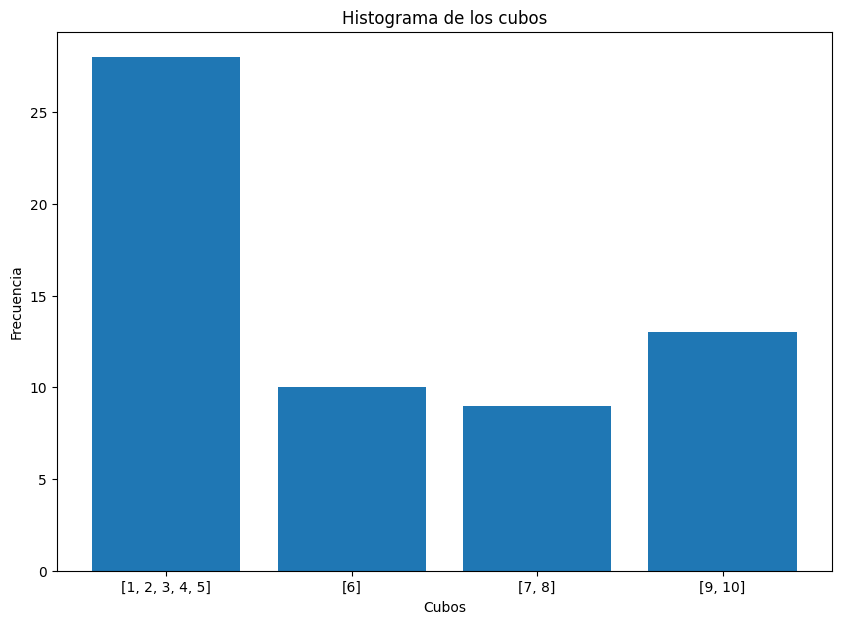

In [65]:
hist_generator = HistogramGeneratorVOpt(f, B)
hist_generator.generate()
hist_generator.save_histogram('./src')  # specify your directory